In [1]:
# Standard imports
import numpy as np
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.metrics import accuracy_score,roc_auc_score, roc_curve
import joblib
import matplotlib.pyplot as plt
import os
from scipy.special import expit
import sys
import plotting
np.random.seed(0)


# We need XGBoost 1.6.0. I had installed it already in a seperate area that I point to below. 
# Alternative, you could open a jupyter terminal and run "pip install xgboost==1.6.0"
sys.path.insert(0, '/mnt/scratch/pmeiring/miniconda3/lib/python3.12/site-packages')
os.environ['PYTHONPATH'] = '/mnt/scratch/pmeiring/miniconda3/lib/python3.12/site-packages:'

# Then import XGboost (and double-check version)
import xgboost as xg
print("XGBoost version = ",xg.__version__)

# Set environmental variables
os.environ['PATH'] = '/opt/Xilinx/Vivado/2019.2/bin:' + os.environ['PATH']
os.environ["XILINX_AP_INCLUDE"] = "/mnt/scratch/pmeiring/l1tnetmet/HLS_arbitrary_Precision_Types/include/"
os.environ["JSON_ROOT"] = "/mnt/scratch/pmeiring/l1tnetmet/json/include"

# Import Conifer (and check version)
import conifer
print("Conifer version = ",conifer.__version__)

Matplotlib created a temporary config/cache directory at /tmp/matplotlib-9klp8bu_ because the default path (/home/jovyan/.cache/matplotlib) is not a writable directory; it is highly recommended to set the MPLCONFIGDIR environment variable to a writable directory, in particular to speed up the import of Matplotlib and to better support multiprocessing.


XGBoost version =  1.6.0
Conifer version =  0.2b0


In [2]:
import json

# Load XGboost model
modelDir="l1netmet"
modelFile="0811/max_depth_4/model.model"
modelConf="0811/max_depth_4/model.json"
features=["Jet_0_eta","Jet_0_phi","Jet_0_pt","Jet_1_eta","Jet_1_phi","Jet_1_pt","Jet_2_eta","Jet_2_phi","Jet_2_pt","Jet_3_eta","Jet_3_phi","Jet_3_pt","methf_0_pt","ntt_0_pt"]

xgb_model = xg.Booster()
xgb_model.load_model('%s/%s'%(modelDir,modelFile))
with open('%s/%s'%(modelDir,modelConf), 'r') as file:
    config = json.load(file)

print(json.dumps(config, indent=2))

[16:44:21] WARNING: ../src/objective/regression_obj.cu:203: reg:linear is now deprecated in favor of reg:squarederror.
{
  "learner": {
    "attributes": {
      "best_iteration": "19",
      "best_ntree_limit": "20",
      "scikit_learn": "{\"n_estimators\": 20, \"objective\": \"reg:linear\", \"max_depth\": 4, \"max_leaves\": null, \"max_bin\": null, \"grow_policy\": null, \"learning_rate\": null, \"verbosity\": null, \"booster\": null, \"tree_method\": null, \"gamma\": null, \"min_child_weight\": null, \"max_delta_step\": null, \"subsample\": null, \"sampling_method\": null, \"colsample_bytree\": null, \"colsample_bylevel\": null, \"colsample_bynode\": null, \"reg_alpha\": null, \"reg_lambda\": null, \"scale_pos_weight\": null, \"base_score\": null, \"missing\": NaN, \"num_parallel_tree\": null, \"random_state\": null, \"n_jobs\": null, \"monotone_constraints\": null, \"interaction_constraints\": null, \"importance_type\": null, \"gpu_id\": null, \"validate_parameters\": null, \"pred

Modified Configuration
--------------------------------------------------
ProjectName:         my_prj
OutputDir:           l1netmet/conifer_prj_hls
XilinxPart:          xcu250-figd2104-2L-e
ClockPeriod:         5
Pipeline:            True
Precision:           ap_fixed<10,3>
--------------------------------------------------


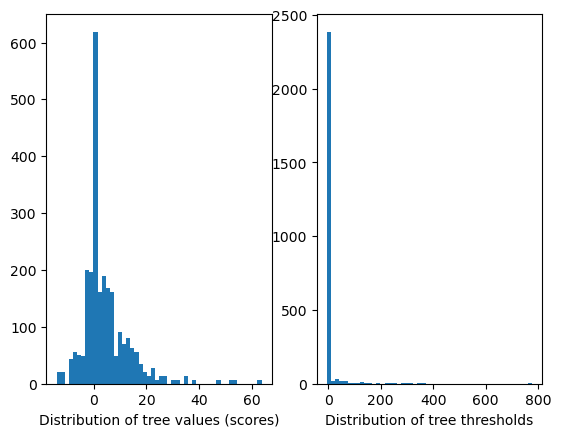

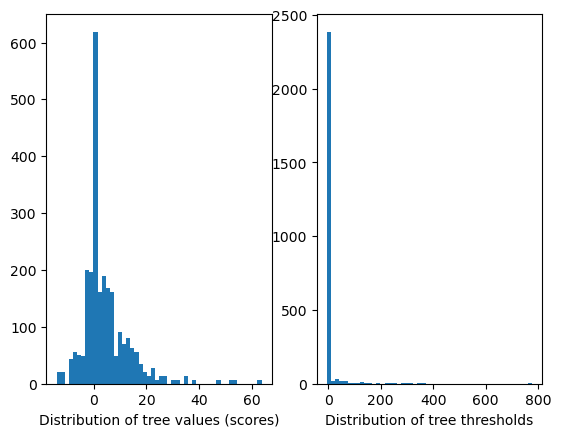

In [3]:
# Conifer configuration (HLS backend)
cfg_hls = conifer.backends.xilinxhls.auto_config()
cfg_hls['OutputDir'] = '%s/conifer_prj_hls'%(modelDir)
cfg_hls['XilinxPart'] = 'xcu250-figd2104-2L-e'
cfg_hls['Precision'] = 'ap_fixed<10,3>'

print('Modified Configuration\n' + '-' * 50)
plotting.print_dict(cfg_hls)
print('-' * 50)

# Convert the XGboost model to a Conifer model (0.2b0)
cnf_model_hls = conifer.model(xgb_model, conifer.converters.xgboost, conifer.backends.xilinxhls, cfg_hls)
os.system("rm -rf %s/conifer_prj_hls"%(modelDir))
cnf_model_hls.compile()

# Convert the XGboost model to a Conifer model (1.50)
# cnf_model_hls = conifer.converters.convert_from_xgboost(xgb_model, cfg_hls)
# cnf_red_hls.compile()

# Plot the model weights and thresholds
cnf_model_hls.profile()

5884 events
14 features
offline MET:  [[71.11617279]
 [44.31915665]
 [19.3438797 ]
 [95.59349823]
 [55.31311417]
 [53.03701782]
 [38.00814438]
 [24.29307175]
 [61.71192169]
 [20.68158531]]
L1 BDT MET (xgboost):  [59.444176 27.562521 56.11547  44.934135 91.57603  36.846504 48.646835
 22.67434  52.78194  38.95954 ]
L1 BDT MET (conifer):  [-2.4296875 -0.484375   2.78125    3.5078125  3.5625     3.7109375
 -3.4921875 -1.21875   -3.8046875  2.03125  ]


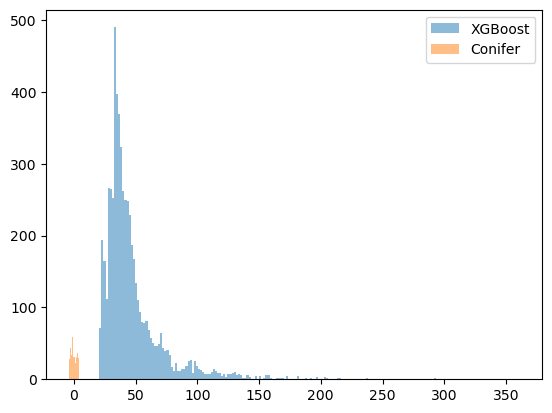

In [4]:
# Load training/validation data to run the inference
x_train = np.load("%s/x_train.npy"%(modelDir))
y_train = np.load("%s/y_train.npy"%(modelDir))
x_valid = np.load("%s/x_valid.npy"%(modelDir))
y_valid = np.load("%s/y_valid.npy"%(modelDir))
print (len(x_train), "events" )
print (len(x_train[0]),"features")

# Truth label (offline MET)
print ("offline MET: ",y_train[:10])

# Prediction with XGBoost
train_data = xg.DMatrix( x_train, label=y_train, feature_names=features)
y_xgb = xgb_model.predict(train_data)
print("L1 BDT MET (xgboost): ",y_xgb[:10])

# Prediction with Conifer (HLS Backend)
y_cnf_hls_= cnf_model_hls.decision_function(x_train)
y_cnf_hls = expit(y_cnf_hls_)
y_cnf_hls_=y_cnf_hls_.reshape(-1)
print("L1 BDT MET (conifer): ",y_cnf_hls_[:10])

# Overlay the XGBoost and Conifer prediction
plt.hist(y_xgb, bins=200, alpha=0.5, label="XGBoost")
plt.hist(y_cnf_hls_, bins=200, alpha=0.5, label="Conifer")
plt.legend()
plt.show()

In [ ]:
# Run the model synthesis. This can take a long time, depending on the model :)
report=cnf_red_hls.build()

In [ ]:
# Read the build report and print resource + performance estimates
import hls4ml
hls4ml.report.print_vivado_report(report)